In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
df = pd.read_csv(r"C:\Users\SACHIN\OneDrive\Desktop\Mini Project\PS_transaction_log.csv",encoding='ISO-8859-1')
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.drop(['nameOrig','nameDest'],axis=1,inplace=True)

In [5]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 436.9+ MB


In [8]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [9]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [10]:
le=LabelEncoder()
df['type']=le.fit_transform(df['type'])

In [11]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']])

x=pd.DataFrame(scaled_features, columns=['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [13]:
# Sample exactly 50,000 rows
df_sample = df.sample(50000, random_state=42)

# Identify label column
target_column = "isFraud" 

# Split X and y
X = df_sample.drop(target_column, axis=1)
y = df_sample[target_column]


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
results = []
model_scores_dict = {}

def evaluate(model_name, y_true, scores):
    scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)
    
    results.append({
        "Model": model_name,
        "ROC-AUC": roc_auc_score(y_true, scores_norm),
        "Precision": precision_score(y_true, scores_norm > 0.5),
        "Recall": recall_score(y_true, scores_norm > 0.5),
        "F1-Score": f1_score(y_true, scores_norm > 0.5)
    })

    model_scores_dict[model_name] = scores_norm


In [17]:
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train_scaled)
scores_iso = -iso.score_samples(X_test_scaled)
evaluate("Isolation Forest", y_test, scores_iso)


In [18]:
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(X_train_scaled)
scores_lof = -lof.score_samples(X_test_scaled)
evaluate("Local Outlier Factor", y_test, scores_lof)


In [19]:
ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm.fit(X_train_scaled)
scores_oc = -ocsvm.score_samples(X_test_scaled)
evaluate("One-Class SVM", y_test, scores_oc)


In [20]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_scaled)
distances = np.linalg.norm(
    X_test_scaled - kmeans.cluster_centers_[kmeans.predict(X_test_scaled)],
    axis=1
)
evaluate("K-Means Distance", y_test, distances)


In [21]:
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train_scaled)
X_test_recon = pca.inverse_transform(pca.transform(X_test_scaled))
recon_error = np.mean((X_test_scaled - X_test_recon)**2, axis=1)
evaluate("PCA Reconstruction", y_test, recon_error)


In [22]:
df_results = pd.DataFrame(results)
df_results


,Model,ROC-AUC,Precision,Recall,F1-Score
0,Isolation Forest,0.878709,0.012658,0.500000,0.024691
1,Local Outlier Factor,0.888866,0.000000,0.000000,0.000000
2,One-Class SVM,0.855076,0.037037,0.285714,0.065574
3,K-Means Distance,0.869446,0.000000,0.000000,0.000000
4,PCA Reconstruction,0.951868,0.000000,0.000000,0.000000


Performance Table (ROC-AUC, Precision, Recall, F1-Score)


PCA Reconstruction has the highest ROC-AUC (0.95), meaning it separates normal vs anomaly scores better than the other models.

Precision is extremely low for all models, indicating a high number of false positives — common in highly imbalanced fraud datasets.

Isolation Forest and One-Class SVM show some recall, meaning they catch some actual fraud cases.

LOF, K-Means, and PCA have 0 recall → they fail to flag true anomalies at the default 0.5 threshold.

One-Class SVM has the highest F1 score among all (still very low), meaning it balances recall and precision slightly better than others.

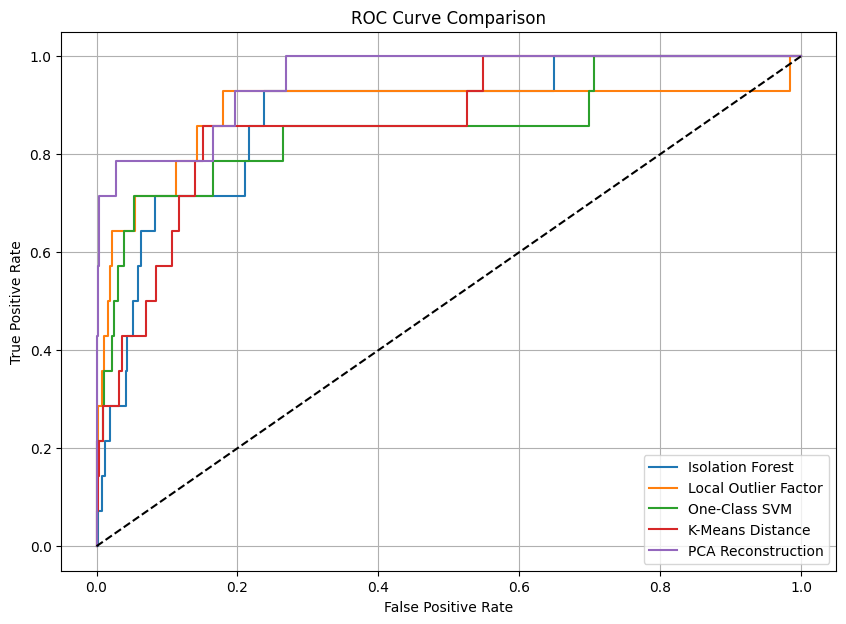

In [23]:
plt.figure(figsize=(10, 7))

for model_name, scores in model_scores_dict.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=model_name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


ROC Curve Comparison


All curves are well above the diagonal, meaning all models perform better than random guessing.

PCA (purple line) has the strongest ROC curve, showing the highest true positive rate across almost all false positive rates.

Isolation Forest and LOF have similar ROC performance, both maintaining good separation ability.

K-Means and One-Class SVM show moderate ROC performance, weaker than PCA and IF.

ROC AUC values match the plot: PCA > LOF ≈ IF > K-Means > OCSVM.

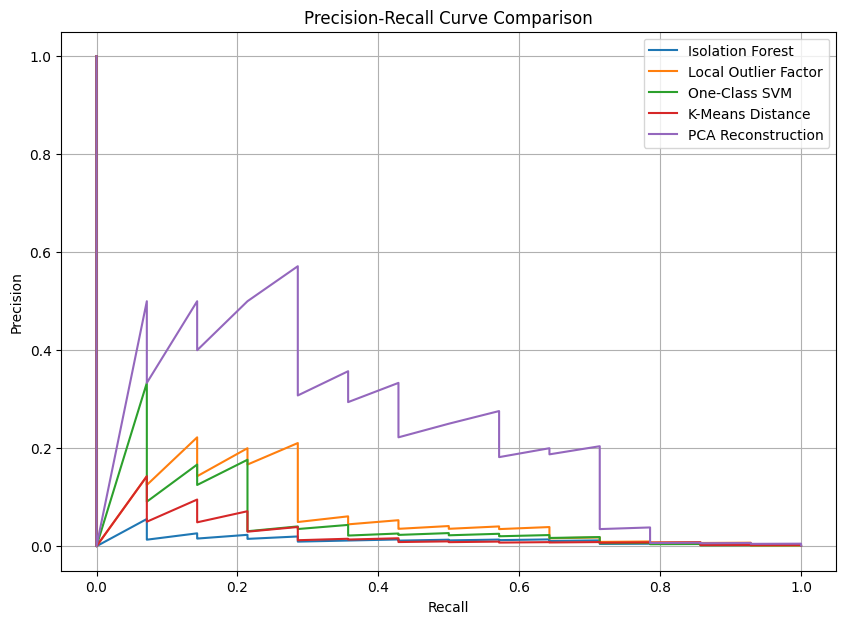

In [24]:
plt.figure(figsize=(10, 7))

for model_name, scores in model_scores_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, scores)
    plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


Precision–Recall (PR) Curve Comparison


PCA again shows the highest precision across most recall values, meaning when it detects anomalies, they are more likely to be true.

All curves drop steeply, showing how extremely hard fraud detection is in imbalanced data.

Isolation Forest and LOF maintain low but stable precision, performing better than K-means.

One-Class SVM shows short peaks, meaning it can achieve moderate precision at very low recall.

PR curves indicate that models struggle because anomalies are very rare — precision collapses quickly as recall rises.

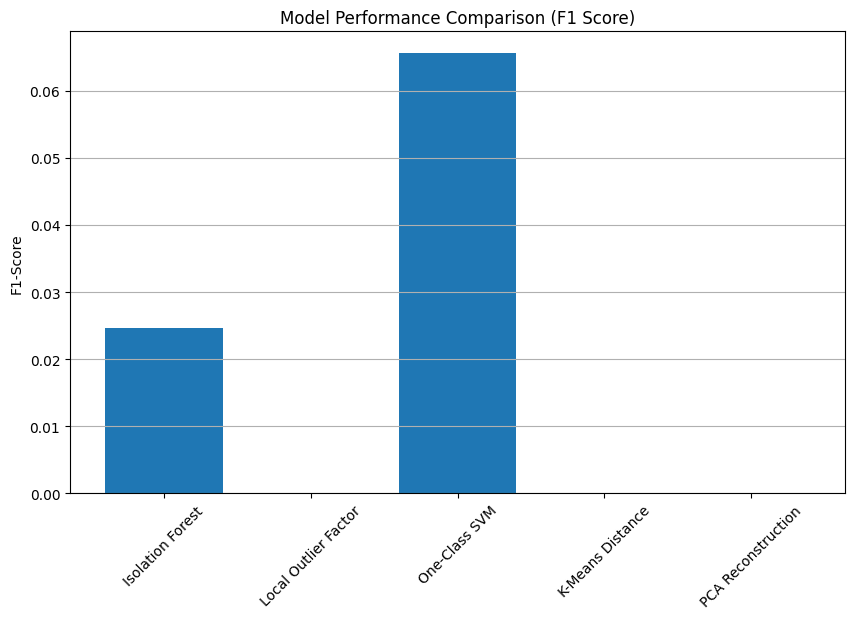

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(df_results["Model"], df_results["F1-Score"])
plt.xticks(rotation=45)
plt.ylabel("F1-Score")
plt.title("Model Performance Comparison (F1 Score)")
plt.grid(axis='y')
plt.show()


F1-Score Bar Chart


One-Class SVM has the highest F1 score, despite its poor ROC, meaning it balances precision and recall slightly better.

Isolation Forest is second, showing it detects some frauds but with high false positives.

LOF, K-Means, PCA have F1 = 0, meaning they detected no true positives at threshold 0.5.

This emphasizes that default thresholds fail in unsupervised fraud detection.

The chart highlights the huge difficulty of achieving both high recall and precision simultaneously on imbalance-heavy fraud data.

Combined Summary 

All five unsupervised models were tested on a 50,000-record fraud dataset.

ROC curves show that every model performs better than random, with PCA having the strongest ROC-AUC (~0.95).

Despite high ROC-AUC, PCA, LOF, and K-Means fail to catch actual frauds, resulting in 0 precision, 0 recall, and 0 F1-score at default thresholds.

Only Isolation Forest and One-Class SVM detect some true anomalies, giving non-zero recall, although precision remains low due to many false positives.

PR curves show steep drops in precision as recall increases, highlighting the difficulty of detecting rare fraud cases.

One-Class SVM (F1 ≈ 0.066) and Isolation Forest (F1 ≈ 0.024) perform better than the other models, but overall F1 scores remain low.

This demonstrates that unsupervised fraud detection is extremely challenging due to the high class imbalance and noisy patterns.

While PCA separates the classes well according to ROC-AUC, it fails in practical fraud detection.

Isolation Forest and One-Class SVM offer the most realistic detection ability, though they still suffer from low precision.